In [12]:
import pandas as pd
import re, os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

one_hot_df = pd.read_csv('Data/allData/PrisonAdmissionsCleanOneHotEncoding.csv')
one_hot_df.drop(columns=['STATE', 'RACE', 'OFFDETAIL', 'OFFGENERAL'], inplace=True)

In [13]:
one_hot_df.head()

,SEX,EDUCATION,ADMITYR,SENTLGTH,AGEADMIT,AK,AL,AR,AZ,CA,...,larceny,motor vehicle theft,murder,negligent manslaugher,other property,other violent,public order,rape/SA,robbery,unspecified
0,1.0,2.0,1991.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,1.0,1991.0,0.0,1.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.0,2.0,1991.0,3.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1.0,1991.0,3.0,1.0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1.0,2.0,1991.0,2.0,2.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
one_hot_df = one_hot_df.dropna()  # Drop rows with missing values

In [16]:
# "independent" variables
feature_cols = list(one_hot_df.columns.values)
feature_cols.remove('SENTLGTH')

X = one_hot_df[feature_cols] # Features
y = one_hot_df['SENTLGTH'] # Target variable

# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [9]:
# replace all the NaNs with 0s
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [17]:
# "independent" variables
feature_cols = list(one_hot_df.columns.values)
feature_cols.remove('SENTLGTH')

X = one_hot_df[feature_cols] # Features
y = one_hot_df['SENTLGTH'] # Target variable

# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rf = RandomForestClassifier(max_depth=15, max_leaf_nodes=120, n_estimators=90, max_features=50)
history = rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# compare training and test accuracy
print("Training Accuracy: " + str(rf.score(X_train, y_train)))
print("Test Accuracy: " + str(rf.score(X_test, y_test)))

mae = str(np.mean(abs(rf_y_pred - y_test)))
print("Mean Absolute Error: " + mae)

cf_mat = confusion_matrix(y_test, rf_y_pred)
print(cf_mat)

# save model
import pickle
pickle.dump(rf, open('prisonAdmissionsModel.sav', 'wb'))


Training Accuracy: 0.4643583621419964
Test Accuracy: 0.46410403088174135
Mean Absolute Error: 0.8783776904612761
[[205884   1291 144353   7896   2886   6762     29      0]
 [ 38310  25479  98850   6291   1238   4630     14      0]
 [ 81009  16168 608513  67373  15292  14389    124      0]
 [ 38122   5758 332240 119261  31901   8463    683      0]
 [ 22080   1793 156416  49029  48632   6239   3245      0]
 [  7149    593  26440   6161  16058  61880   2241      0]
 [   382     45   7074   3775   7255   2011   6146      0]
 [     0      0    129      1     21      0      0      0]]


/var/folders/v1/ljzyxbgj1xx_syzq56dgnsk00000gn/T/ipykernel_88975/3356348162.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))


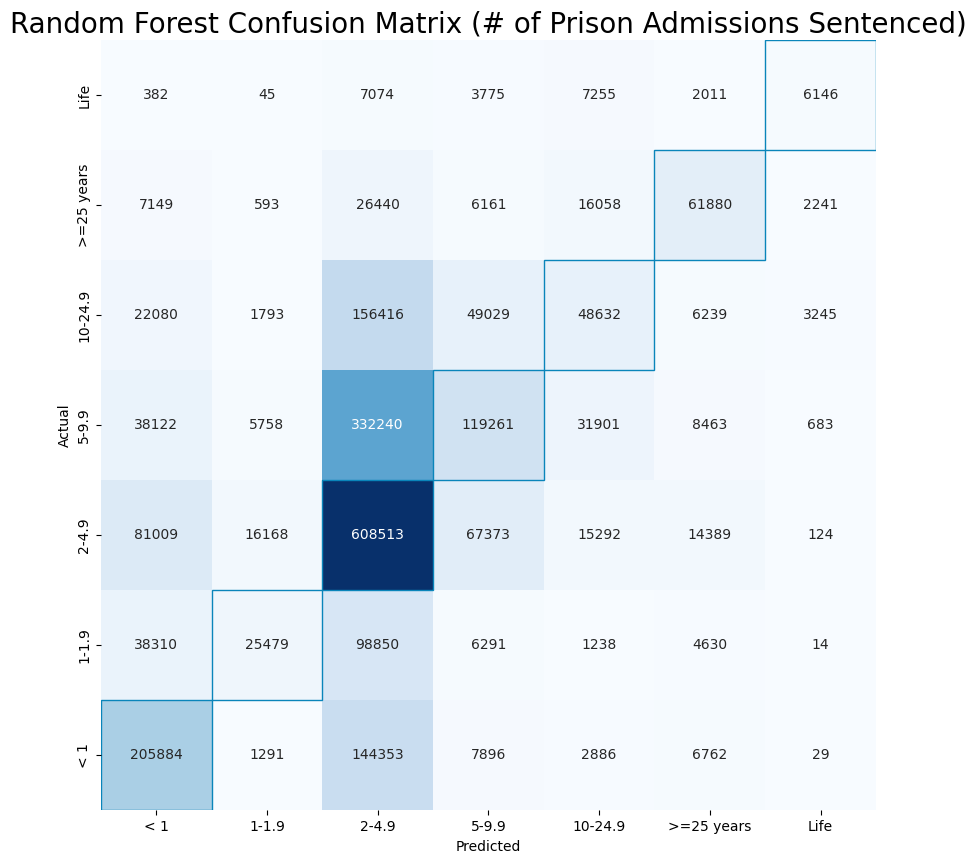

In [48]:
# remove the 8th column and row from the confusion matrix (MISSING VALUES)
ncf_mat = np.delete(cf_mat, 7, 0)
ncf_mat = np.delete(ncf_mat, 7, 1)

labels = ["< 1", "1-1.9", "2-4.9", "5-9.9", "10-24.9", ">=25 years", "Life"]

# plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(ncf_mat, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.invert_yaxis()
cb = ax.collections[0].colorbar
cb.remove()

# label the confusion matrix using the labels list
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_major_locator(ticker.IndexLocator(base=1, offset=0.5))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))

# outline the diagonal cells
for i in range(0,7):
    rect = plt.Rectangle((i,i), 1, 1, fill=False, color='#0A85BA')
    ax.add_patch(rect)

plt.title("Random Forest Confusion Matrix (# of Prison Admissions Sentenced)", fontsize=20)

# save the plot
plt.savefig('prisonAdmissionsConfusionMatrix.png', dpi=300, bbox_inches='tight')

[369101 174812 802868 536428 287434 120522  26688]
[0.55779854 0.14575086 0.75792409 0.22232434 0.16919362 0.51343323
 0.23029077]


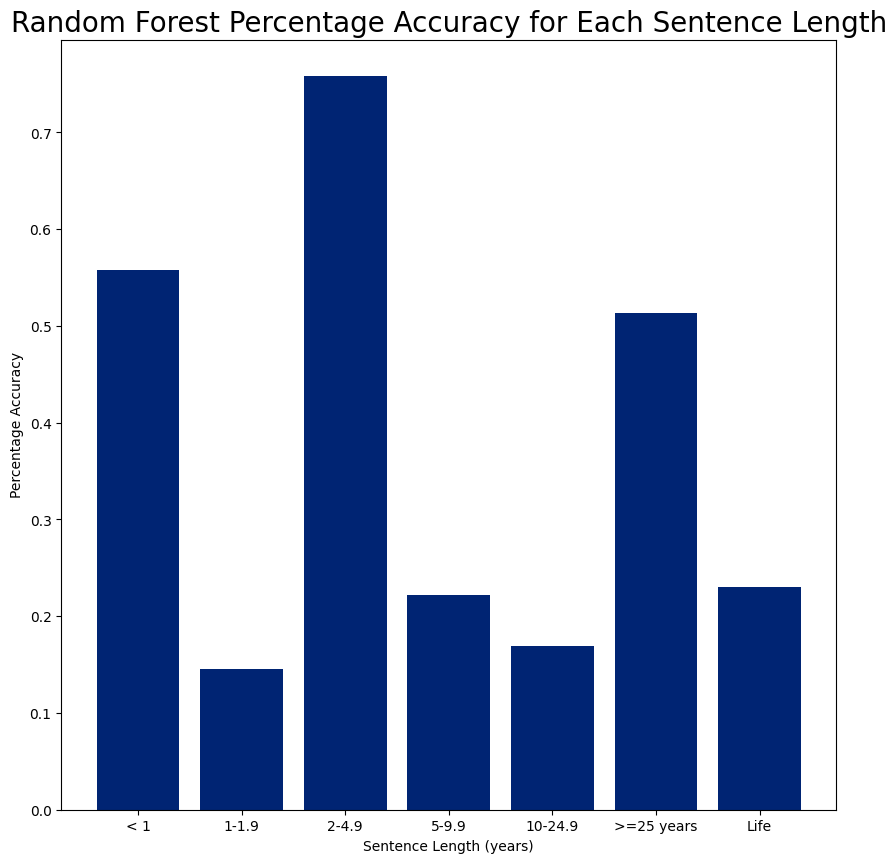

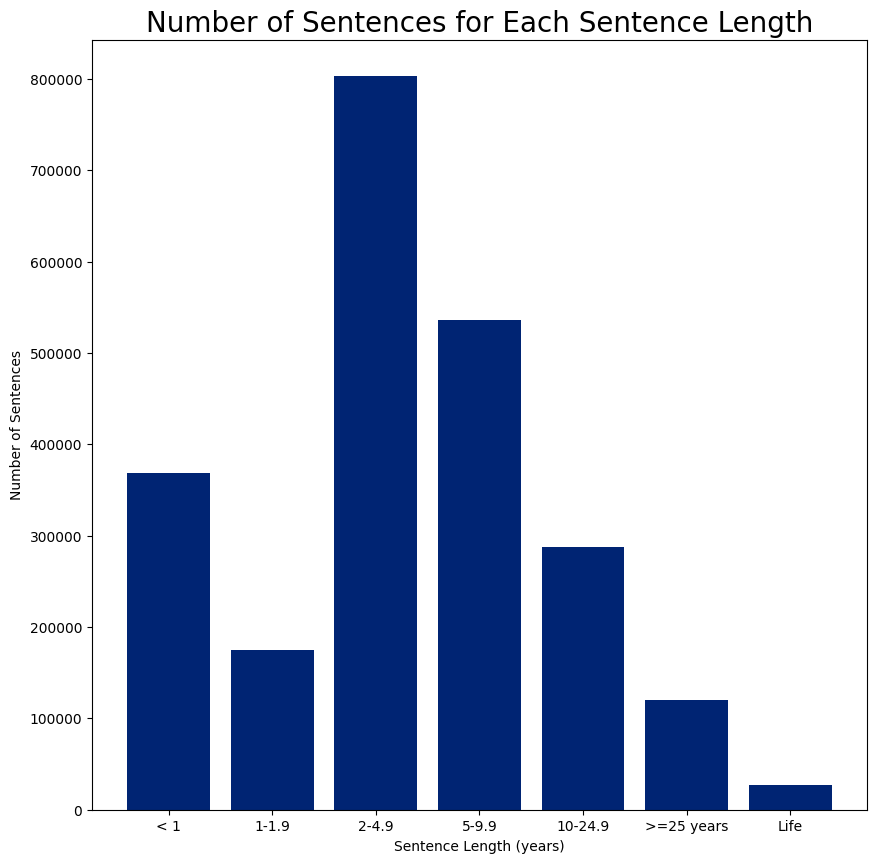

In [51]:
# based on the confusion matrix, determine the percentage accuracy for each sentence length 

# get the total number of sentences for each sentence length
total_sent = np.sum(ncf_mat, axis=1)
print(total_sent)
correct_pred = np.diagonal(ncf_mat)
accuracy = np.divide(correct_pred, total_sent)
print(accuracy)

# plot the percentage accuracy for each sentence length
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(labels, accuracy, color='#002473')
ax.set_xlabel('Sentence Length (years)')
ax.set_ylabel('Percentage Accuracy')
ax.set_title('Random Forest Percentage Accuracy for Each Sentence Length', fontsize=20)

plt.savefig('prisonAdmissionsPercentageAccuracy.png', dpi=300, bbox_inches='tight')

# plot the number of sentences for each sentence length
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(labels, total_sent, color='#002473')
ax.set_xlabel('Sentence Length (years)')
ax.set_ylabel('Number of Sentences')
ax.set_title('Number of Sentences for Each Sentence Length', fontsize=20)

plt.savefig('prisonAdmissionsNumberSentences.png', dpi=300, bbox_inches='tight')


In [52]:
# calculate overall accuracy
overall_accuracy = np.sum(correct_pred) / np.sum(total_sent)
print("Overall Accuracy: " + str(overall_accuracy))

Overall Accuracy: 0.4641342656328939


In [7]:
import pandas as pd
import re, os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle

In [55]:
texas_df = pd.read_csv('Data/stateData/oneHotDfTexas.csv')
florida_df = pd.read_csv('Data/stateData/oneHotDfFlorida.csv')
new_york_df = pd.read_csv('Data/stateData/oneHotDfNewYork.csv')
illinois_df = pd.read_csv('Data/stateData/oneHotDfIllinois.csv')
north_carolina_df = pd.read_csv('Data/stateData/oneHotDfNC.csv')
california_df = pd.read_csv('Data/stateData/oneHotDfCA.csv')
arizona_df = pd.read_csv('Data/stateData/oneHotDfAZ.csv')
sc_df = pd.read_csv('Data/stateData/oneHotDfSC.csv')
mo_df = pd.read_csv('Data/stateData/oneHotDfMO.csv')
in_df = pd.read_csv('Data/stateData/oneHotDfIN.csv')
pa_df = pd.read_csv('Data/stateData/oneHotDfPA.csv')

In [56]:
detailed_offense = ["murder", "negligent manslaugher", "rape/SA", "robbery", "assault", "other violent", "burglary", "larceny", "motor vehicle theft", "fraud", "other property", "drugs", "public order", "unspecified"]

def train_text_model(df, year, offense):
    # only want rows from 2020
    new_df = df[df['ADMITYR'] == float(year)]

    # drop columns that are not needed
    new_df = new_df.drop(['ADMITYR'], axis=1)
    new_df = new_df[new_df['OFFGENERAL'] == offense]
    new_df = new_df.drop(detailed_offense, axis=1)
    
    # "independent" variables
    feature_cols = list(new_df.columns.values)
    feature_cols.remove('SENTLGTH')

    x = new_df[feature_cols] # Features
    y = new_df['SENTLGTH'] # Target variable

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    return X_train, X_test, y_train, y_test

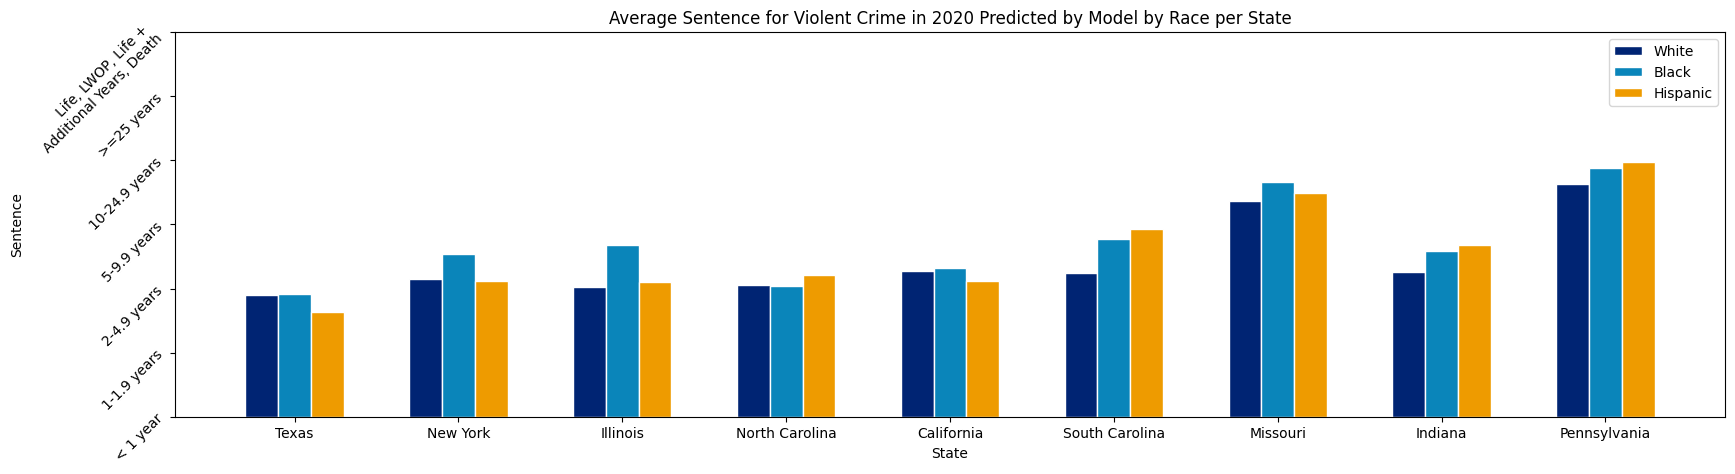

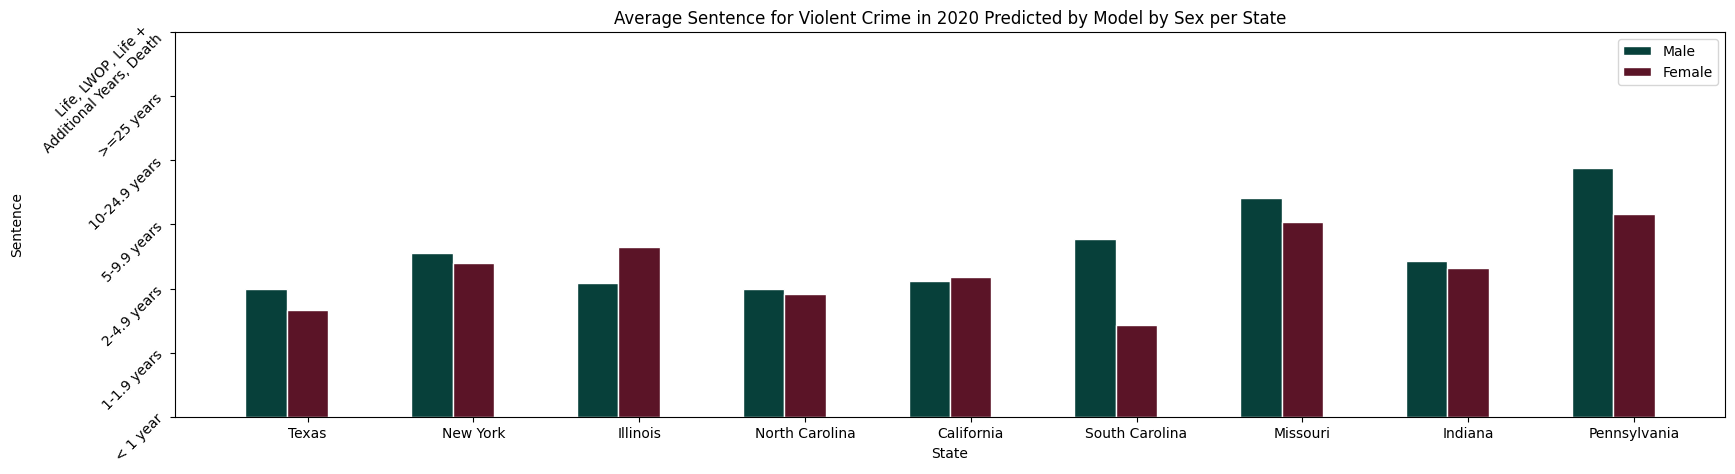

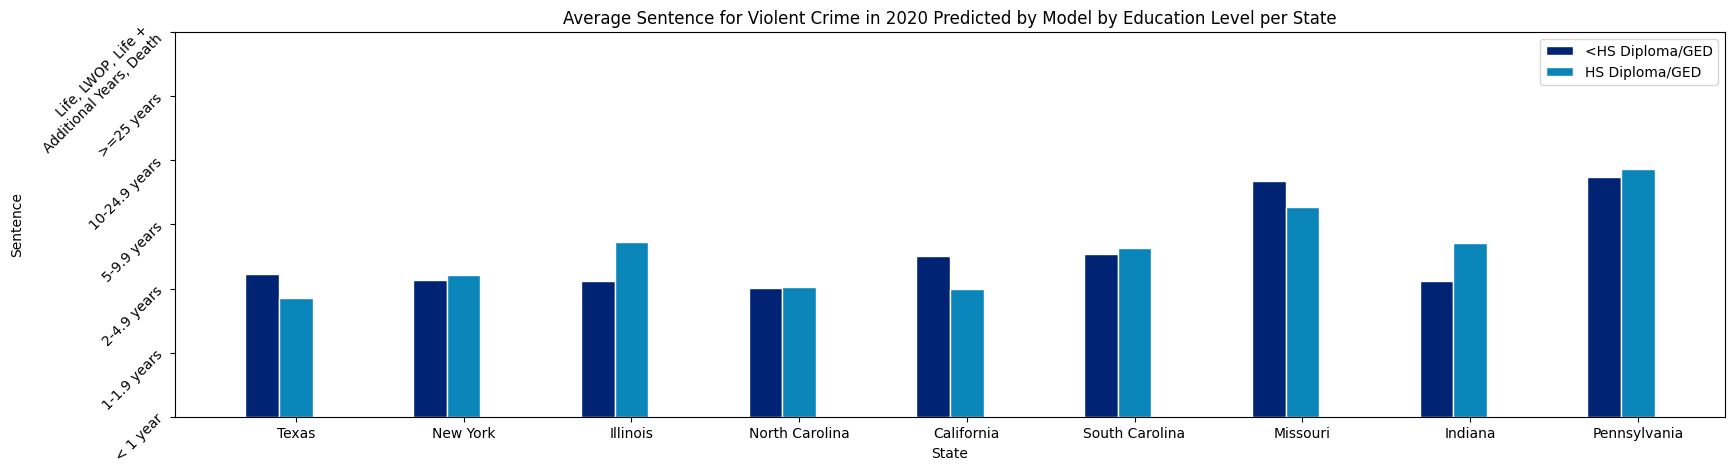

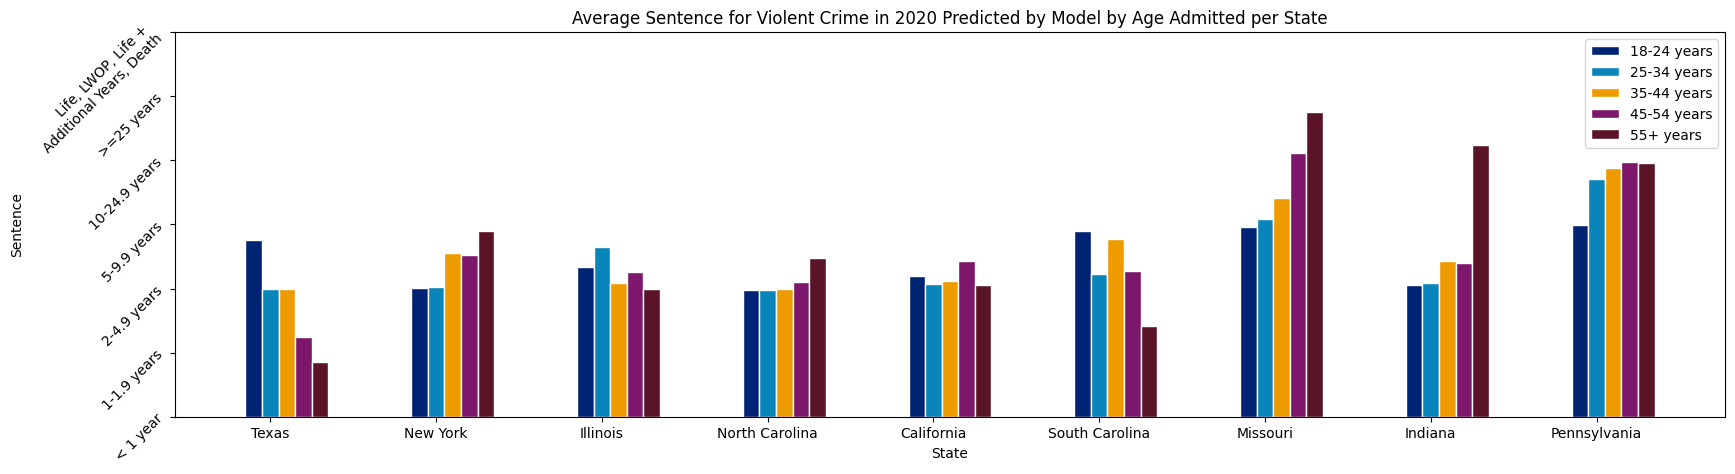

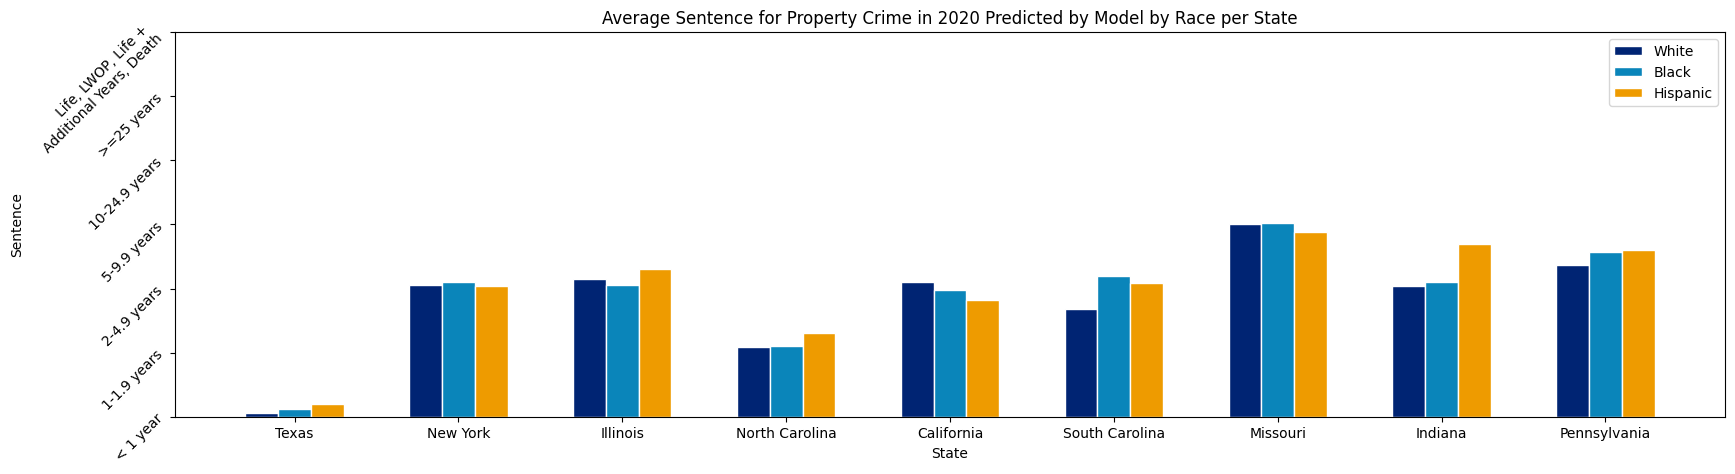

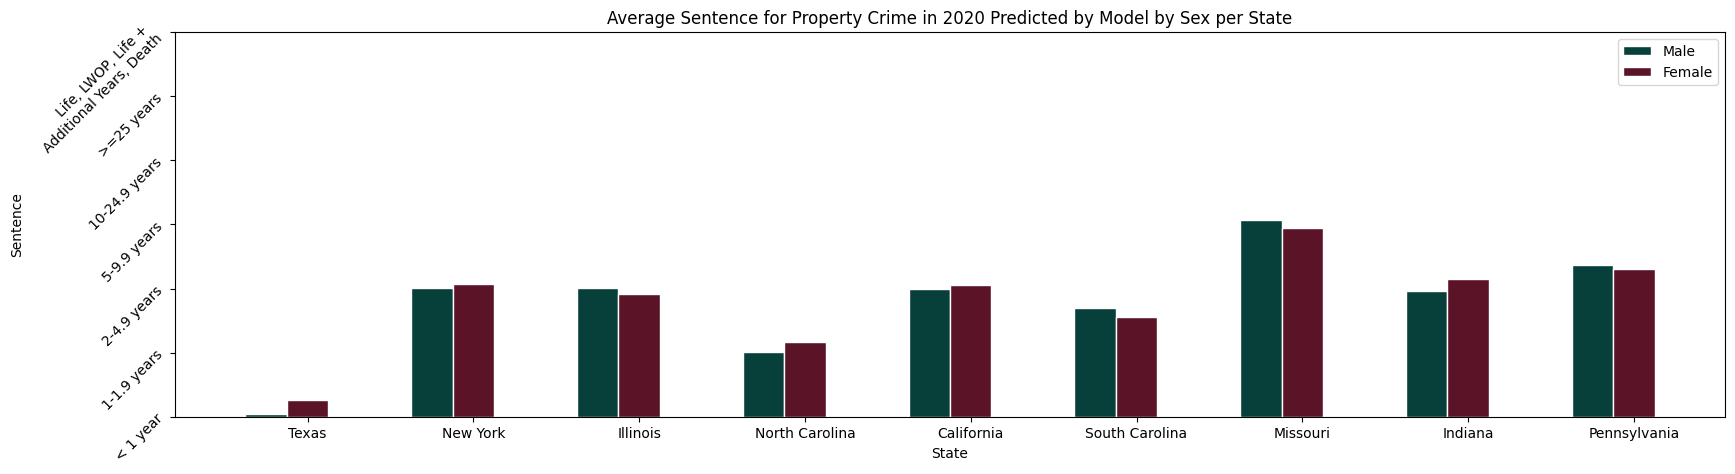

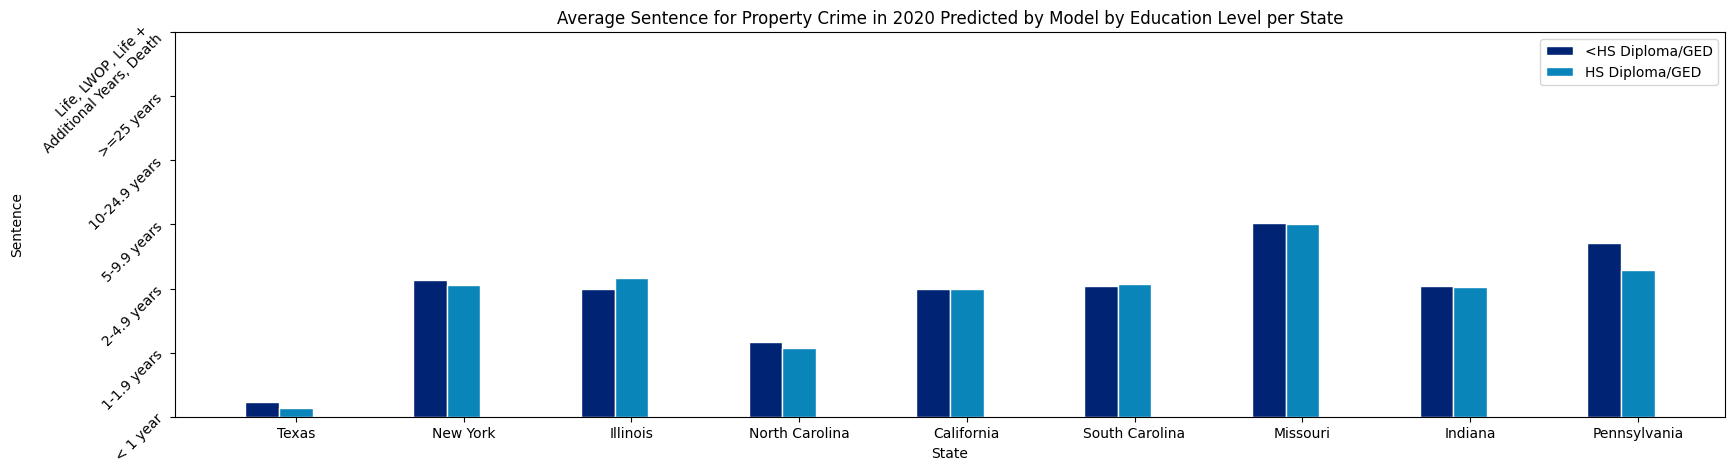

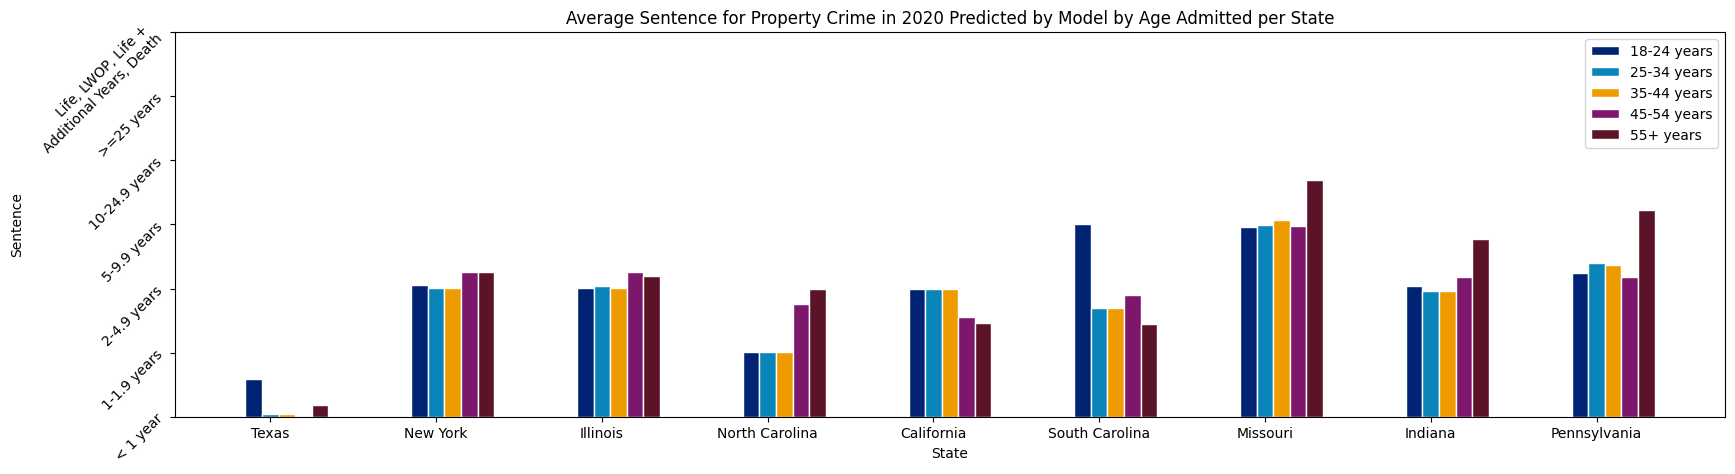

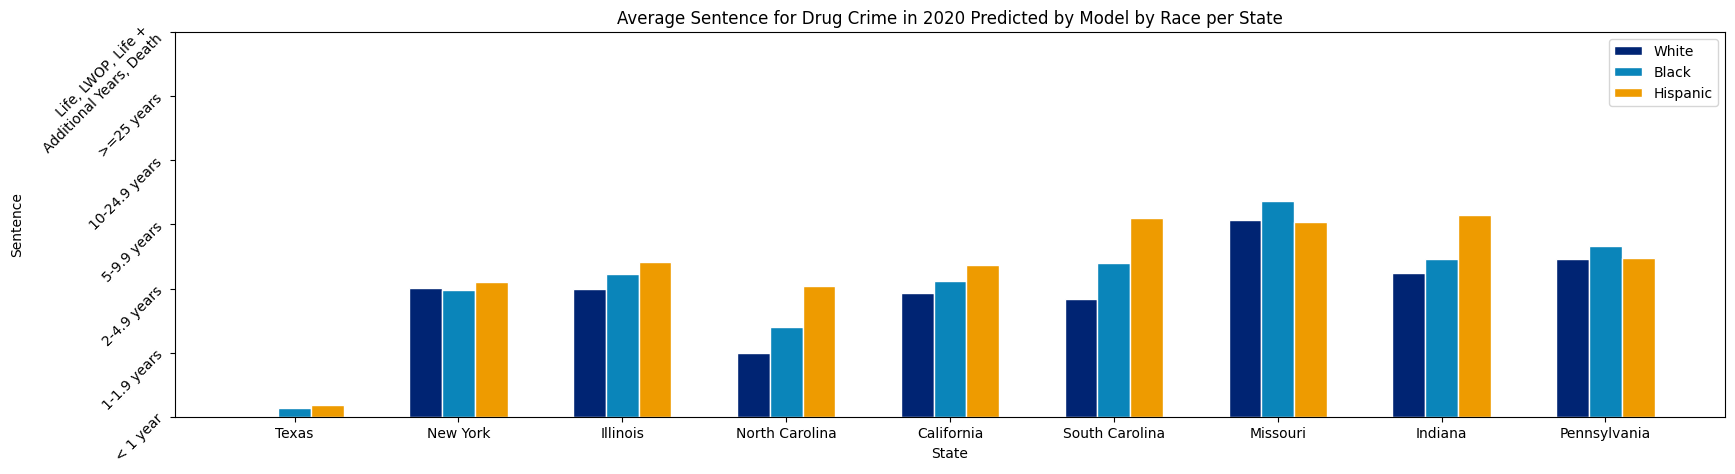

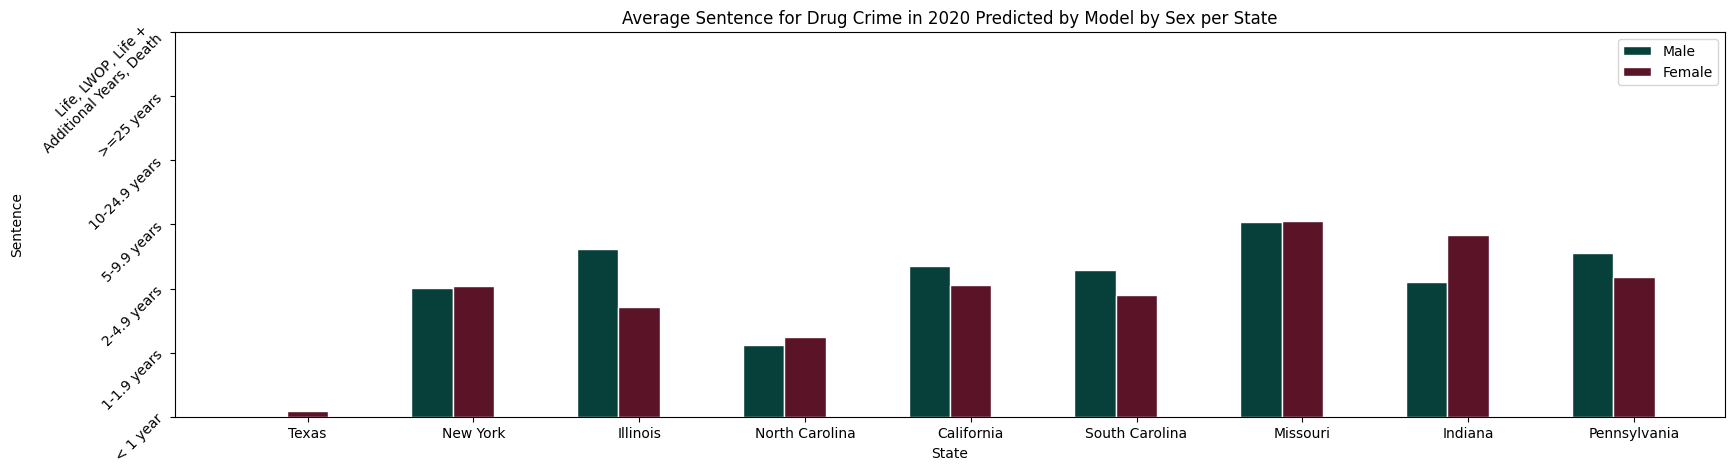

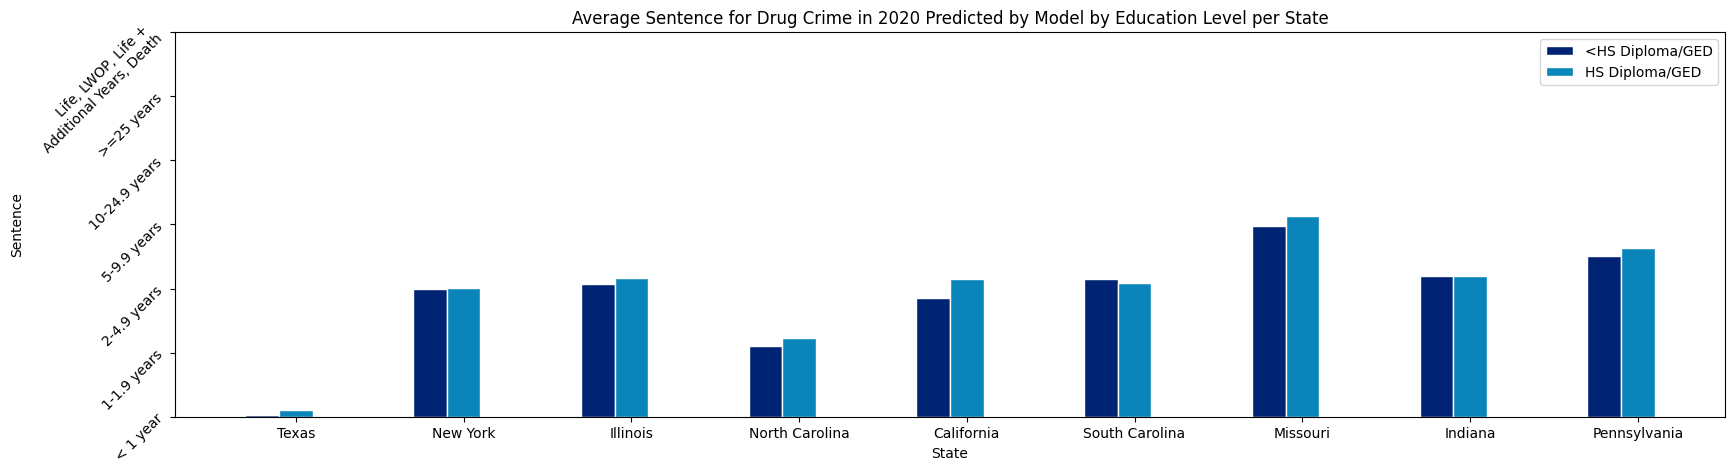

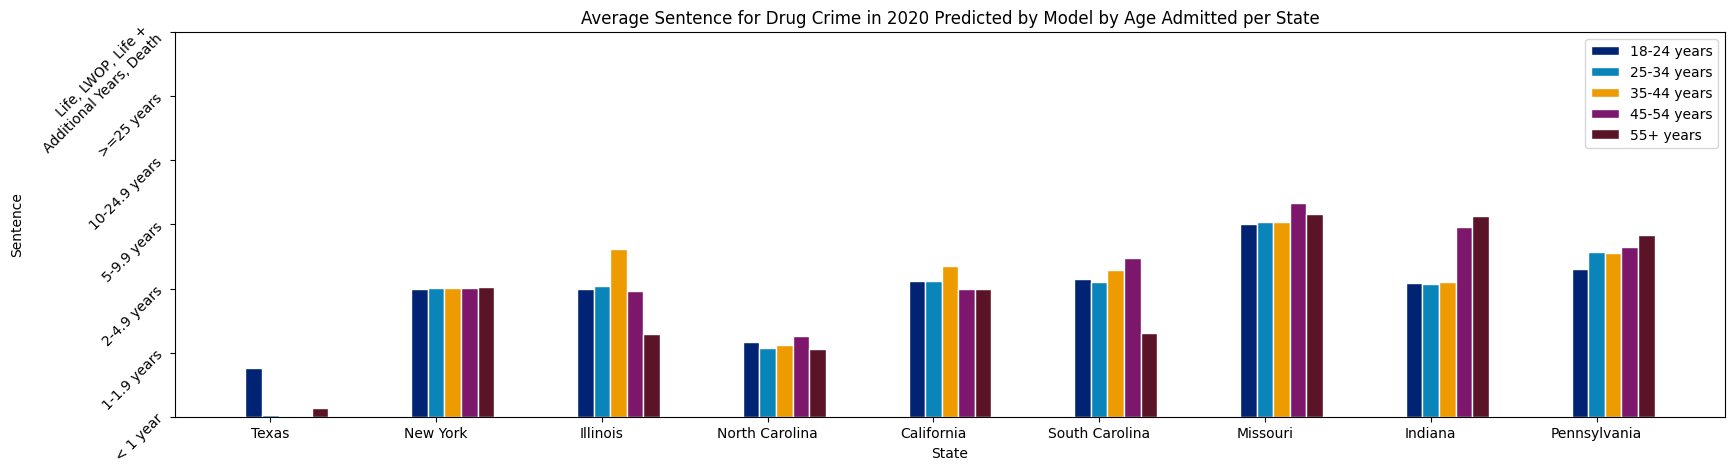

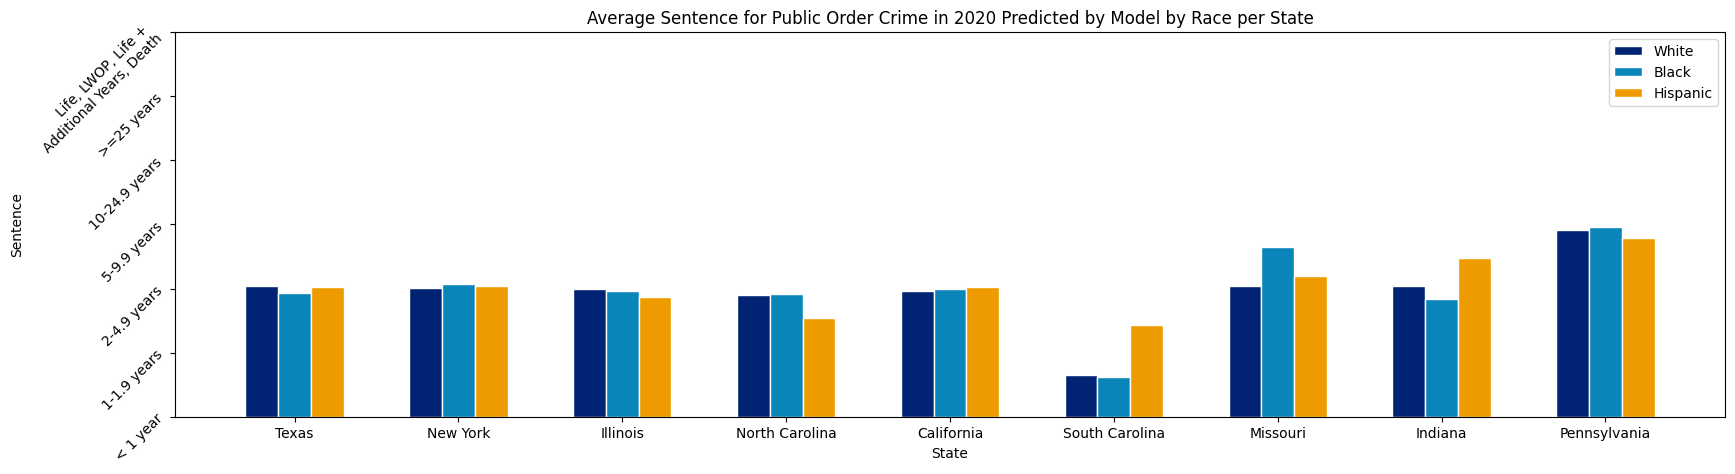

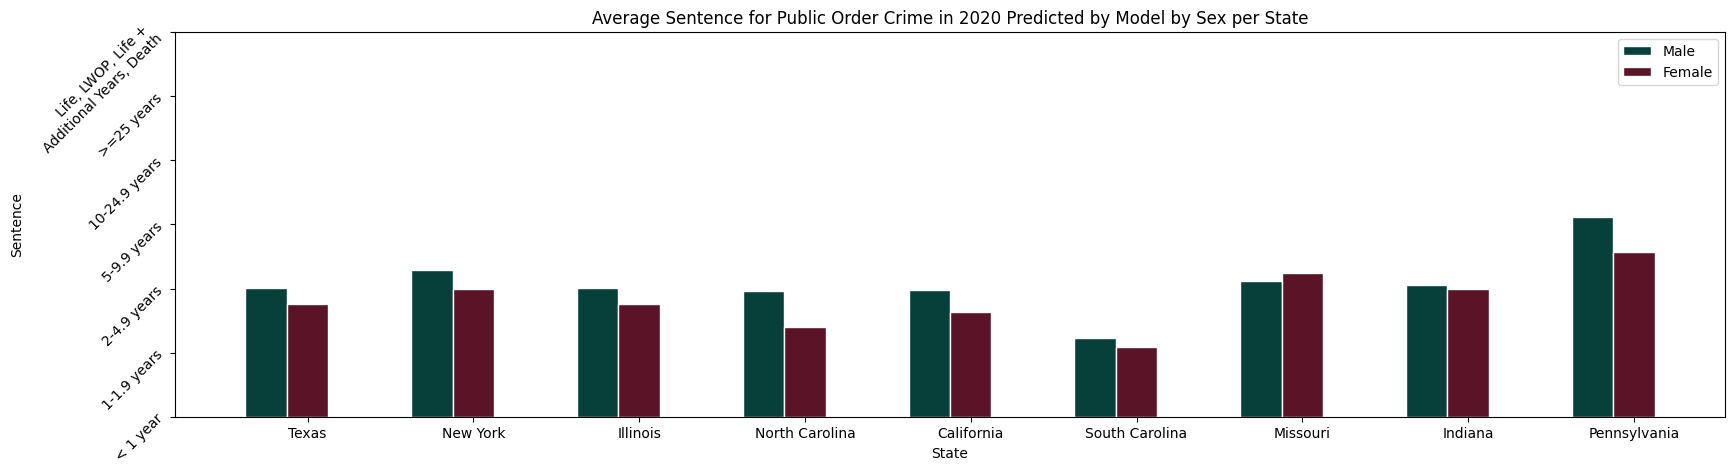

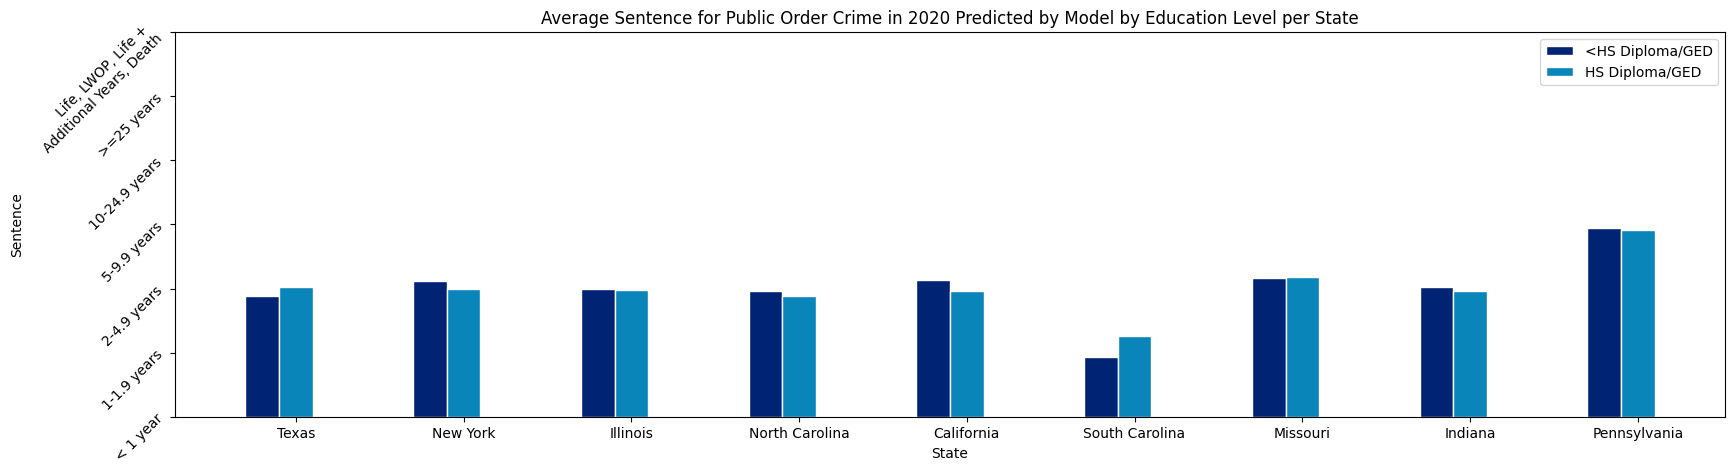

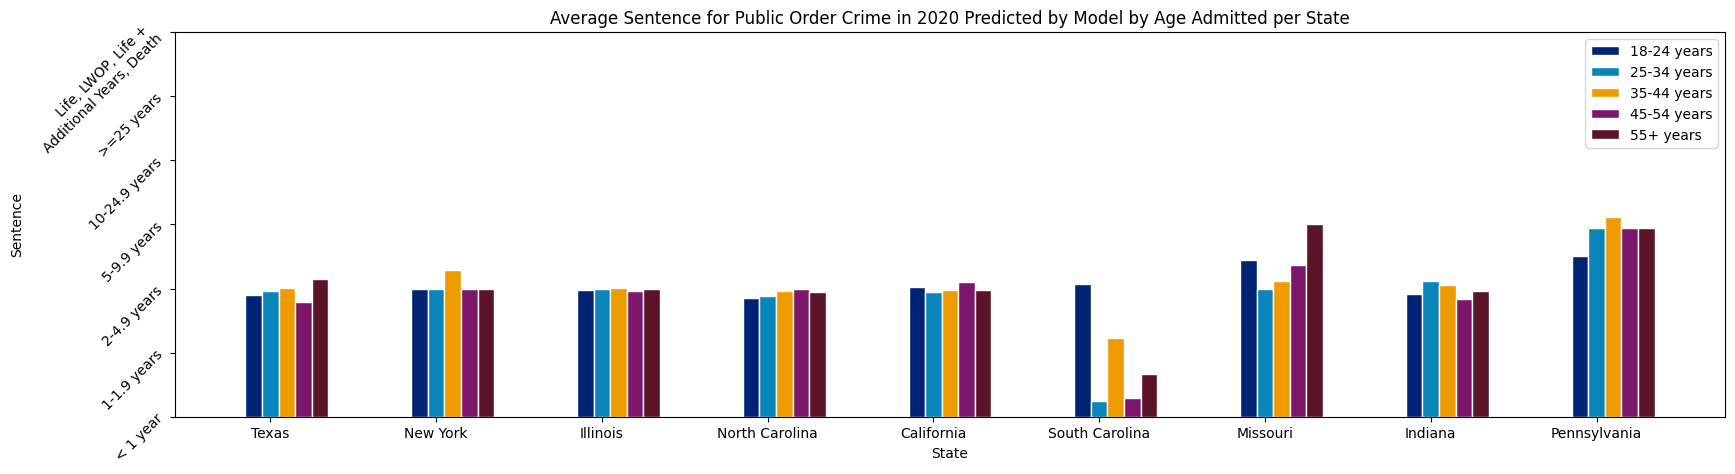

In [63]:
# Random Forest Model
feature_importance = []
feature_cols = []
states = ['Texas', 'New York', 'Illinois', 'North Carolina', 'California', 'South Carolina', 'Missouri', 'Indiana', 'Pennsylvania']
off_general = ['Violent', 'Property', 'Drug', 'Public Order']
colors = ["#002473", "#0A85BA", "#ee9b00", "#7d176c", "#5b1427","#e7d498",  "#07403a", "#d15400", "#1d085b", "#91080c","#431a51", "#bb3e03",  "#DFA591", "#BD0058"]

for inx, off in enumerate(off_general):
    
    means = []
    white_means = []
    black_means = []
    hispanic_means = []
    male_means = []
    female_means = []
    no_hs_means = []
    hs_means = []
    some_college_means = []
    young_means = []
    youngadult_means = []
    middle_means = []
    middle_aged_means = []
    old_means = []

    # only using states for which data is available in 2020
    for index, state_df in enumerate([texas_df, new_york_df, illinois_df, north_carolina_df, california_df, sc_df, mo_df, in_df, pa_df]):
        
        X_train, X_test, y_train, y_test = train_text_model(state_df, 2020, inx + 1)

        rf = RandomForestClassifier(max_depth=15, max_leaf_nodes=120, n_estimators=90, max_features=50)
        rf.fit(X_train, y_train)

        # using datapoints for white since it is the largest uniform population
        white_df = X_test[X_test['white'] == 1]
        white_df['white'].values[:] = 0
        
        black_clone = white_df.copy()
        black_clone['black'].values[:] = 1

        hispanic_clone = white_df.copy()
        hispanic_clone['hispanic'].values[:] = 1


        female_clone = X_test[X_test['SEX'] == 1]
        female_clone['SEX'].values[:] = 2

        education_clone = X_test[X_test['EDUCATION'] == 1]
        education_clone['EDUCATION'].values[:] = 2

        age_clone_base = X_test[X_test['AGEADMIT'] == 2]
        age_clone_1 = age_clone_base.copy()
        age_clone_1['AGEADMIT'].values[:] = 1

        age_clone_2 = age_clone_base.copy()
        age_clone_2['AGEADMIT'].values[:] = 2
        age_clone_3 = age_clone_base.copy()
        age_clone_3['AGEADMIT'].values[:] = 3
        age_clone_4 = age_clone_base.copy()
        age_clone_4['AGEADMIT'].values[:] = 4
        age_clone_5 = age_clone_base.copy()
        age_clone_5['AGEADMIT'].values[:] = 5

        rf_pred = rf.predict(X_test)
        rf_predw = rf.predict(X_test[X_test['white'] == 1])
        rf_predb = rf.predict(black_clone)
        rf_predh = rf.predict(hispanic_clone)
        rf_predm = rf.predict(X_test[X_test['SEX'] == 1])
        rf_predf = rf.predict(female_clone)
        rf_prednhs = rf.predict(X_test[X_test['EDUCATION'] == 1])
        rf_predhs = rf.predict(education_clone)
        # rf_predc = rf.predict(X_test[X_test['EDUCATION'] == 3])
        rf_predy = rf.predict(age_clone_1)
        rf_predya = rf.predict(age_clone_2)
        rf_predm = rf.predict(age_clone_3)
        rf_predma = rf.predict(age_clone_4)
        rf_predo = rf.predict(age_clone_5)

        # print average sentence length predicted by model 
        # print("Average sentence length predicted by model: ", np.mean(rf_pred))
        means.append(np.mean(rf_pred))

        # print average sentence length for white, black, and hispanic inmates
        # print("Average sentence length for white inmates: ", np.mean(rf_predw))
        white_means.append(np.mean(rf_predw))

        # print("Average sentence length for black inmates: ", np.mean(rf_predb))
        black_means.append(np.mean(rf_predb))

        # print("Average sentence length for hispanic inmates: ", np.mean(rf_predh))
        hispanic_means.append(np.mean(rf_predh))

        # prediction by sex
        male_means.append(np.mean(rf_predm))
        female_means.append(np.mean(rf_predf))

        # prediction by education 
        no_hs_means.append(np.mean(rf_prednhs))
        hs_means.append(np.mean(rf_predhs))
        # some_college_means.append(np.mean(rf_predc))

        # prediction by age
        young_means.append(np.mean(rf_predy))
        youngadult_means.append(np.mean(rf_predya))
        middle_means.append(np.mean(rf_predm))
        middle_aged_means.append(np.mean(rf_predma))
        old_means.append(np.mean(rf_predo))

        # compare training and test accuracy
        # print("Training Accuracy: " + str(rf.score(X_train, y_train)))
        # print("Test Accuracy: " + str(rf.score(X_test, y_test)))
        # print("Mean Absolute Error: " + str(np.mean(abs(rf_pred - y_test))))

        # save the trained model
        # filename = 'Models/' + states[index] + 'GradientBoostingModel.sav'
        # pickle.dump(rf, open(filename, 'wb'))

    # Race Plot
    bar_width = 0.20 
    r1 = np.arange(len(white_means))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, white_means, color=colors[0], width=bar_width, edgecolor='white', label='White')
    plt.bar(r2, black_means, color=colors[1], width=bar_width, edgecolor='white', label='Black')
    plt.bar(r3, hispanic_means, color=colors[2], width=bar_width, edgecolor='white', label='Hispanic')
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.yticks(np.arange(0, 7, 1), labels=["< 1 year", "1-1.9 years", "2-4.9 years", "5-9.9 years", "10-24.9 years", ">=25 years", "Life, LWOP, Life + \nAdditional Years, Death"])
    plt.yticks(rotation=45)
    plt.xlabel("State")
    plt.xticks([r + bar_width for r in range(len(white_means))], states)
    plt.ylabel("Sentence")
    plt.title("Average Sentence for " + off_general[inx] + " Crime in 2020 Predicted by Model by Race per State")
    plt.legend()
    plt.savefig("ModelGraphs/averageSentence" + off_general[inx] + ".png")
    plt.show()

    # Sex Plot
    bar_width = 0.25 
    r1 = np.arange(len(male_means))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, male_means, color=colors[6], width=bar_width, edgecolor='white', label='Male')
    plt.bar(r2, female_means, color=colors[4], width=bar_width, edgecolor='white', label='Female')
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.yticks(np.arange(0, 7, 1), labels=["< 1 year", "1-1.9 years", "2-4.9 years", "5-9.9 years", "10-24.9 years", ">=25 years", "Life, LWOP, Life + \nAdditional Years, Death"])
    plt.yticks(rotation=45)
    plt.xlabel("State")
    plt.xticks([r + bar_width for r in range(len(male_means))], states)
    plt.ylabel("Sentence")
    plt.title("Average Sentence for " + off_general[inx] + " Crime in 2020 Predicted by Model by Sex per State")
    plt.legend()
    plt.savefig("ModelGraphs/averageSentencebySex" + off_general[inx] + ".png")
    plt.show()

    # Education Plot
    bar_width = 0.20
    r1 = np.arange(len(no_hs_means))
    r2 = [x + bar_width for x in r1]
    
    plt.bar(r1, no_hs_means, color=colors[0], width=bar_width, edgecolor='white', label='<HS Diploma/GED')
    plt.bar(r2, hs_means, color=colors[1], width=bar_width, edgecolor='white', label='HS Diploma/GED')
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.yticks(np.arange(0, 7, 1), labels=["< 1 year", "1-1.9 years", "2-4.9 years", "5-9.9 years", "10-24.9 years", ">=25 years", "Life, LWOP, Life + \nAdditional Years, Death"])
    plt.yticks(rotation=45)
    plt.xlabel("State")
    plt.xticks([r + bar_width for r in range(len(hs_means))], states)
    plt.ylabel("Sentence")
    plt.title("Average Sentence for " + off_general[inx] + " Crime in 2020 Predicted by Model by Education Level per State")
    plt.legend()
    plt.savefig("ModelGraphs/averageSentencebyEducation" + off_general[inx] + ".png")
    plt.show()

    # Age Plot
    bar_width = 0.10
    r1 = np.arange(len(male_means))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    
    plt.bar(r1, young_means, color=colors[0], width=bar_width, edgecolor='white', label='18-24 years')
    plt.bar(r2, youngadult_means, color=colors[1], width=bar_width, edgecolor='white', label='25-34 years')
    plt.bar(r3, middle_means, color=colors[2], width=bar_width, edgecolor='white', label='35-44 years')
    plt.bar(r4, middle_aged_means, color=colors[3], width=bar_width, edgecolor='white', label='45-54 years')
    plt.bar(r5, old_means, color=colors[4], width=bar_width, edgecolor='white', label='55+ years')
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.yticks(np.arange(0, 7, 1), labels=["< 1 year", "1-1.9 years", "2-4.9 years", "5-9.9 years", "10-24.9 years", ">=25 years", "Life, LWOP, Life + \nAdditional Years, Death"])
    plt.yticks(rotation=45)
    plt.xlabel("State")
    plt.xticks([r + bar_width for r in range(len(male_means))], states)
    plt.ylabel("Sentence")
    plt.title("Average Sentence for " + off_general[inx] + " Crime in 2020 Predicted by Model by Age Admitted per State")
    plt.legend()
    plt.savefig("ModelGraphs/averageSentencebyAgeAdmit" + off_general[inx] + ".png")
    plt.show()



    
